# Bonsai log analysis

In [1]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
#import plotly
#import plotly.tools as tls
#import cufflinks as cf
import pylab
import numpy as np
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#plotly.offline.init_notebook_mode(connected=True)
#cf.go_offline()
#sns.set()#setting seaborn theme for matplotlib
#sns.set_context("talk")# to plot figures in the notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
#pylab.rcParams['figure.figsize'] = (17, 8)
#pylab.rcParams['axes.titlesize'] = 20
#pylab.rcParams['axes.labelsize'] = 20
#pylab.rcParams['xtick.labelsize'] = 20
#pylab.rcParams['ytick.labelsize'] = 20
#pylab.rcParams['legend.fontsize'] = 20
plt.rcParams["figure.figsize"]=20,20
import ast
import glob
import os

## Data Preparation

In [2]:
# Get latest file
list_of_files = glob.glob('*.csv') # * means all if need specific format then *.csv
filename = max(list_of_files, key=os.path.getctime)

#filename = '2021-07-26-12-34-46_test_policy_log.csv'

In [3]:
df = pd.read_csv(filename)

df = df[df['episode'] == 1]
df.head(5)

,state_machines_speed,state_machines_state,state_machines_state_sum,state_conveyors_speed,state_conveyors_state,state_conveyor_buffers,state_conveyor_buffers_full,state_sink_machines_rate,state_sink_machines_rate_sum,state_sink_throughput_delta,...,config_machine_max_speed,config_machine_initial_speed,config_prox_upper_limit,config_prox_lower_limit,config_infeedProx_index1,config_infeedProx_index2,config_dischargeProx_index1,config_dischargeProx_index2,episode,iteration
0,"[100, 100, 100, 100, 100, 100]","[1, 1, 1, 1, 1, 1]",6,"[1000, 1000, 1000, 1000, 1000]","['active', 'active', 'active', 'active', 'acti...","[[50, 50, 50, 50, 50, 50, 50, 50, 50, 50], [50...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",[100],100,[0],...,100,100,100,5,1,2,0,1,1,1
1,"[100, 100, 100, 100, 100, 100]","[1, 1, 1, 1, 1, 1]",6,"[1000, 1000, 1000, 1000, 1000]","['active', 'active', 'active', 'active', 'acti...","[[50, 50, 50, 50, 50, 50, 50, 50, 50, 50], [50...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",[100],100,[0],...,100,100,100,5,1,2,0,1,1,2
2,"[100, 100, 0, 100, 100, 100]","[1, 1, -1, 1, 1, 1]",4,"[1000, 1000, 1000, 1000, 1000]","['active', 'active', 'active', 'active', 'acti...","[[50, 50, 50, 50, 50, 50, 50, 50, 50.0, 100.0]...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, ...",[100],100,[100],...,100,100,100,5,1,2,0,1,1,3
3,"[100, 100, 0, 0, 100, 100]","[1, 1, -1, 0, 1, 1]",3,"[1000, 1000, 1000, 1000, 1000]","['active', 'active', 'active', 'active', 'acti...","[[50, 50, 50, 50, 50, 50, 50, 50, 50.0, 100.0]...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, ...",[100],100,[100],...,100,100,100,5,1,2,0,1,1,4
4,"[100, 100, 0, 0, 0, 100]","[1, 1, -1, 0, 0, 1]",2,"[1000, 1000, 1000, 1000, 1000]","['active', 'active', 'active', 'active', 'acti...","[[50, 50, 50, 50, 50, 50, 50, 50, 50.0, 100.0]...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, ...",[100],100,[100],...,100,100,100,5,1,2,0,1,1,5


In [4]:
selected_columns = [
    'state_machines_speed',
    'state_machines_state',
    'state_conveyor_buffers',
    'state_conveyor_infeed_m1_prox_empty',
    'state_conveyor_infeed_m2_prox_empty',
    'state_conveyor_discharge_p1_prox_full',
    'state_conveyor_discharge_p2_prox_full'
]

for col in selected_columns:
    if col == 'state_conveyor_buffers':
        df[col]= df[col].apply(lambda x: ast.literal_eval(str(x)))
        for i, buffer in enumerate(df[col].iloc[0]):
            df[col+'_'+str(i)+'_'] = df[col].map(lambda x: x[i])
    else:
        df[col] = df[col].apply(lambda x: ast.literal_eval(str(x)))

In [5]:
# flatten the columns
def flatten_column(df, col_lst):
    df_flat = pd.concat([pd.DataFrame(df[x].values.tolist()).add_prefix(x) for x in col_lst], axis=1)
    df = pd.concat([df_flat, df.drop(col_lst, axis=1)], axis=1)
    return df

In [6]:
# Applying the flattening function
selected_columns = [
    'state_machines_speed',
    'state_machines_state',
    'state_conveyor_buffers_0_',
    'state_conveyor_buffers_1_',
    'state_conveyor_buffers_2_',
    'state_conveyor_buffers_3_',
    'state_conveyor_buffers_4_',
    'state_conveyor_infeed_m1_prox_empty',
    'state_conveyor_infeed_m2_prox_empty',
    'state_conveyor_discharge_p1_prox_full',
    'state_conveyor_discharge_p2_prox_full'
]
df_flattened = flatten_column(df, selected_columns)

## Plots

In [7]:
col = [
    'state_machines_speed0',
    'state_machines_speed1',
    'state_machines_speed2',
    'state_machines_speed3',
    'state_machines_speed4',
    'state_machines_speed5',
    'state_conveyor_buffers_0_0',
    'state_conveyor_buffers_0_1',
    'state_conveyor_buffers_0_2',
    'state_conveyor_buffers_0_3',
    'state_conveyor_buffers_0_4',
    'state_conveyor_buffers_0_5',
    'state_conveyor_buffers_0_6',
    'state_conveyor_buffers_0_7',
    'state_conveyor_buffers_0_8',
    'state_conveyor_buffers_0_9',
    'state_conveyor_buffers_1_0',
    'state_conveyor_buffers_1_1',
    'state_conveyor_buffers_1_2',
    'state_conveyor_buffers_1_3',
    'state_conveyor_buffers_1_4',
    'state_conveyor_buffers_1_5',
    'state_conveyor_buffers_1_6',
    'state_conveyor_buffers_1_7',
    'state_conveyor_buffers_1_8',
    'state_conveyor_buffers_1_9',
    'state_conveyor_buffers_2_0',
    'state_conveyor_buffers_2_1',
    'state_conveyor_buffers_2_2',
    'state_conveyor_buffers_2_3',
    'state_conveyor_buffers_2_4',
    'state_conveyor_buffers_2_5',
    'state_conveyor_buffers_2_6',
    'state_conveyor_buffers_2_7',
    'state_conveyor_buffers_2_8',
    'state_conveyor_buffers_2_9',
    'state_conveyor_buffers_3_0',
    'state_conveyor_buffers_3_1',
    'state_conveyor_buffers_3_2',
    'state_conveyor_buffers_3_3',
    'state_conveyor_buffers_3_4',
    'state_conveyor_buffers_3_5',
    'state_conveyor_buffers_3_6',
    'state_conveyor_buffers_3_7',
    'state_conveyor_buffers_3_8',
    'state_conveyor_buffers_3_9',
    'state_conveyor_buffers_4_0',
    'state_conveyor_buffers_4_1',
    'state_conveyor_buffers_4_2',
    'state_conveyor_buffers_4_3',
    'state_conveyor_buffers_4_4',
    'state_conveyor_buffers_4_5',
    'state_conveyor_buffers_4_6',
    'state_conveyor_buffers_4_7',
    'state_conveyor_buffers_4_8',
    'state_conveyor_buffers_4_9',
    'config_bin_maximum_capacity',
    'state_conveyor_infeed_m1_prox_empty0',
    'state_conveyor_infeed_m1_prox_empty1',
    'state_conveyor_infeed_m1_prox_empty2',
    'state_conveyor_infeed_m1_prox_empty3',
    'state_conveyor_infeed_m1_prox_empty4',
    'state_conveyor_infeed_m2_prox_empty0',
    'state_conveyor_infeed_m2_prox_empty1',
    'state_conveyor_infeed_m2_prox_empty2',
    'state_conveyor_infeed_m2_prox_empty3',
    'state_conveyor_infeed_m2_prox_empty4',
    'state_conveyor_discharge_p1_prox_full0',
    'state_conveyor_discharge_p1_prox_full1',
    'state_conveyor_discharge_p1_prox_full2',
    'state_conveyor_discharge_p1_prox_full3',
    'state_conveyor_discharge_p1_prox_full4',
    'state_conveyor_discharge_p2_prox_full0',
    'state_conveyor_discharge_p2_prox_full1',
    'state_conveyor_discharge_p2_prox_full2',
    'state_conveyor_discharge_p2_prox_full3',
    'state_conveyor_discharge_p2_prox_full4',
    'state_machines_state0',
    'state_machines_state1',
    'state_machines_state2',
    'state_machines_state3',
    'state_machines_state4',
    'state_machines_state5',
    'state_sink_throughput_delta_sum',
]

In [8]:
def bplot(dfs, col):
    fig = plt.figure(figsize=(10,8))
    numSubPlots = len(col)
    
    ax1 = plt.subplot(numSubPlots, 1, 1)
    plt.plot(dfs['iteration'], dfs[col[0]], label=col[0], linewidth=1, color = 'blue' )
    plt.xticks(rotation='horizontal')
    plt.legend(loc='upper right')

    for i in range(1,numSubPlots):
        ax2 = plt.subplot(numSubPlots, 1, i+1, sharex=ax1)
        plt.plot(dfs['iteration'], dfs[col[i]], label=col[i], linewidth=1, color = 'blue' )
        plt.xticks(rotation='horizontal')
        plt.legend(loc='upper right')
        
def overlay(dfs, col):
    fig, ax = plt.subplots(1, 1, figsize=(16,8))
    for i in range(len(col)):
        ax.plot(dfs['iteration'], dfs[col[i]], label=col[i])
    ax.legend()

In [9]:
def analyze_machine(dfs, machine):
    fig = plt.figure()
    numSubPlots = 6
    
    ax1 = plt.subplot(numSubPlots, 1, 1)
    plt.plot(dfs['iteration'], dfs['state_machines_speed{}'.format(machine)], label='state_machines_speed{}'.format(machine), linewidth=1)
    plt.xticks(rotation='horizontal')
    plt.legend(loc='upper right')

    ax2 = plt.subplot(numSubPlots, 1, 2, sharex=ax1)
    for i in range(10):
        if machine == 0:
            plt.plot(dfs['iteration'], dfs['state_conveyor_buffers_{}_{}'.format(machine, i)], label='state_conveyor_buffers_{}_{}'.format(machine, i), linewidth=1)
        else:
            plt.plot(dfs['iteration'], dfs['state_conveyor_buffers_{}_{}'.format(machine-1, i)], label='state_conveyor_buffers_{}_{}'.format(machine-1, i), linewidth=1)
    plt.plot(dfs['iteration'], dfs['config_bin_maximum_capacity'], label='config_bin_maximum_capacity', linewidth=3, color='red')
    plt.xticks(rotation='horizontal')
    plt.legend(loc='upper right')
    
    ax3 = plt.subplot(numSubPlots, 1, 3, sharex=ax1)
    for i in range(1, 3):
        if machine == 0:
            plt.plot(dfs['iteration'], dfs['state_conveyor_infeed_m{}_prox_empty{}'.format(i, machine)], label='state_conveyor_infeed_m{}_prox_empty{}'.format(i, machine), linewidth=1)
        else:
            plt.plot(dfs['iteration'], dfs['state_conveyor_infeed_m{}_prox_empty{}'.format(i, machine-1)], label='state_conveyor_infeed_m{}_prox_empty{}'.format(i, machine-1), linewidth=1)
    plt.xticks(rotation='horizontal')
    plt.legend(loc='upper right')
    
    ax4 = plt.subplot(numSubPlots, 1, 4, sharex=ax1)
    for i in range(1, 3):
        if machine == 0:
            plt.plot(dfs['iteration'], dfs['state_conveyor_discharge_p{}_prox_full{}'.format(i, machine)], label='state_conveyor_discharge_p{}_prox_full{}'.format(i, machine), linewidth=1)
        else:
            plt.plot(dfs['iteration'], dfs['state_conveyor_discharge_p{}_prox_full{}'.format(i, machine-1)], label='state_conveyor_discharge_p{}_prox_full{}'.format(i, machine-1), linewidth=1)
    plt.xticks(rotation='horizontal')
    plt.legend(loc='upper right')
    
    ax5 = plt.subplot(numSubPlots, 1, 5, sharex=ax1)
    plt.plot(dfs['iteration'], dfs['state_sink_throughput_delta_sum'], label='state_sink_throughput_delta_sum', linewidth=1)
    plt.xticks(rotation='horizontal')
    plt.legend(loc='upper right')
    
    ax6 = plt.subplot(numSubPlots, 1, 6, sharex=ax1)
    plt.plot(dfs['iteration'], dfs['state_machines_state{}'.format(machine)], label='state_machines_state{}'.format(machine), linewidth=1)
    plt.xticks(rotation='horizontal')
    plt.legend(loc='upper right')

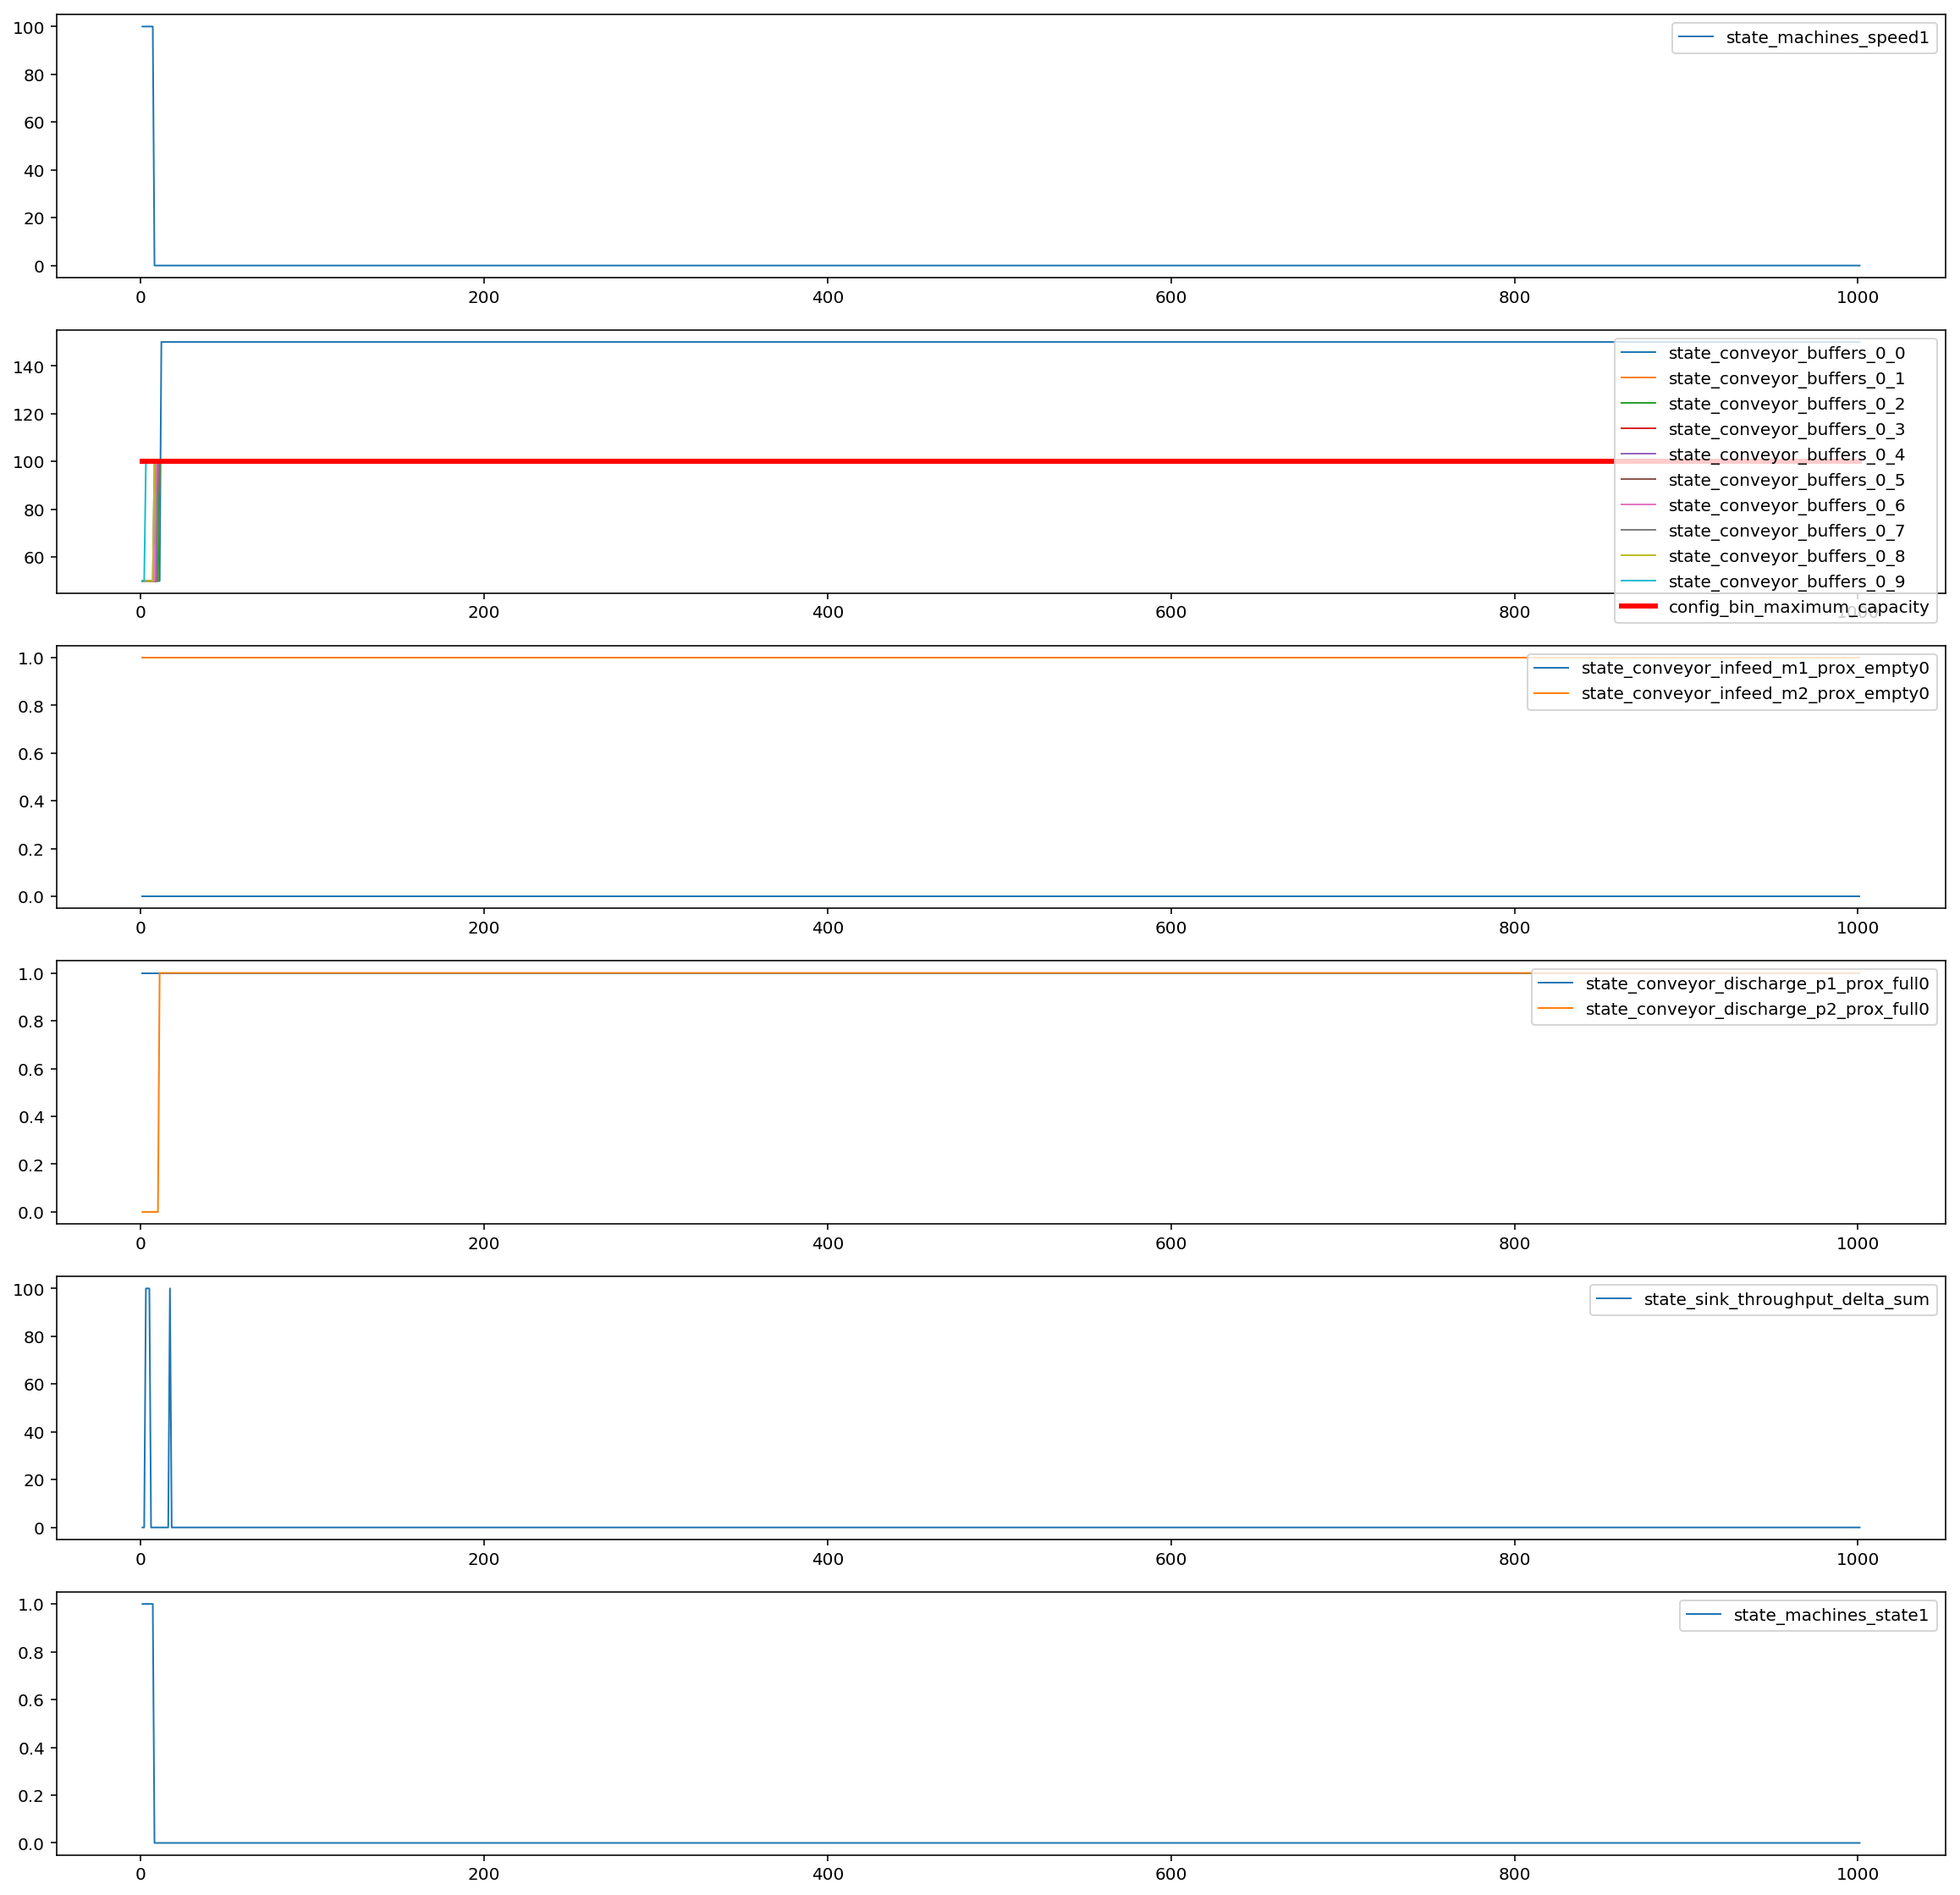

In [12]:
analyze_machine(df_flattened, 1)